In [15]:
# Tratamiento de datos
import numpy as np
import pandas as pd


# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

from scipy import stats

# Preprocesado y modelado
plt.rcParams["figure.figsize"] = (10,8)

In [2]:
# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

# Input
Cargamos los datos:

In [5]:
df = pd.read_csv("data/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Análisis exploratorio

1. ver que tengo en el df y los tipos

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


- variables continuas:
  - `charges`
  - `bmi`
  - `age`
- variables discretas:
  - `sex`
  - `children`
  - `region`


la variable respuesta -- la que se va a intentar predecir. en este caso, será `charges`. el resto de variables serán varables predictoras:
- `age`
- `sex`
- `bmi`
- `children`
- `smoker`
- `region`

2. ver el número de nulos que tengo en el dataset y ver que puedo hacer con ello

una columna es quitable en cuanto a úmero de nulos será el 60%-70% de valores nulos

In [8]:
# Número de datos nulos por columna
# ==============================================================================
df.isnull().sum() / df.shape[0]

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

3. check duplicados -- si hay filas duplicadas, te las zumbas

In [9]:
df.duplicated().sum() / df.shape[0]

0.0007473841554559044

4. check los tipos de datos

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


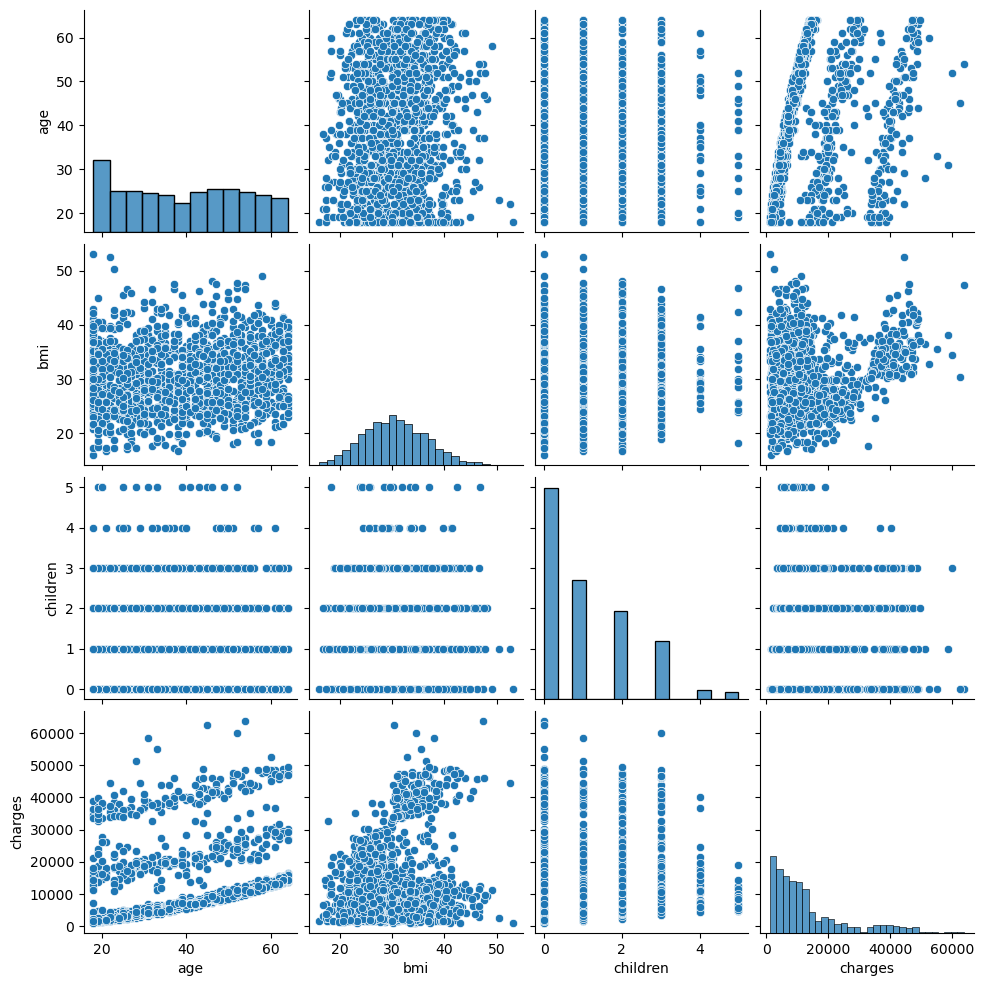

In [11]:
sns.pairplot(data=df);

## Variable respuesta

la variable respuesta en este caso será `charges`.

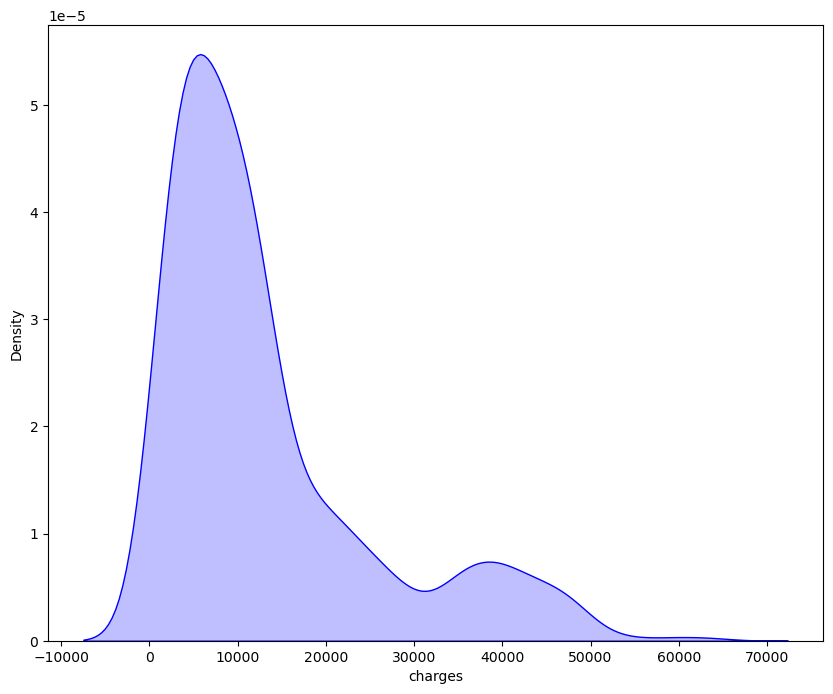

In [12]:
# vamos a ver visualmente como está distribuida la variable respuesta

##esto es un resumen un histograma

sns.kdeplot(
    df.charges, 
    color = "blue", 
    fill = True);

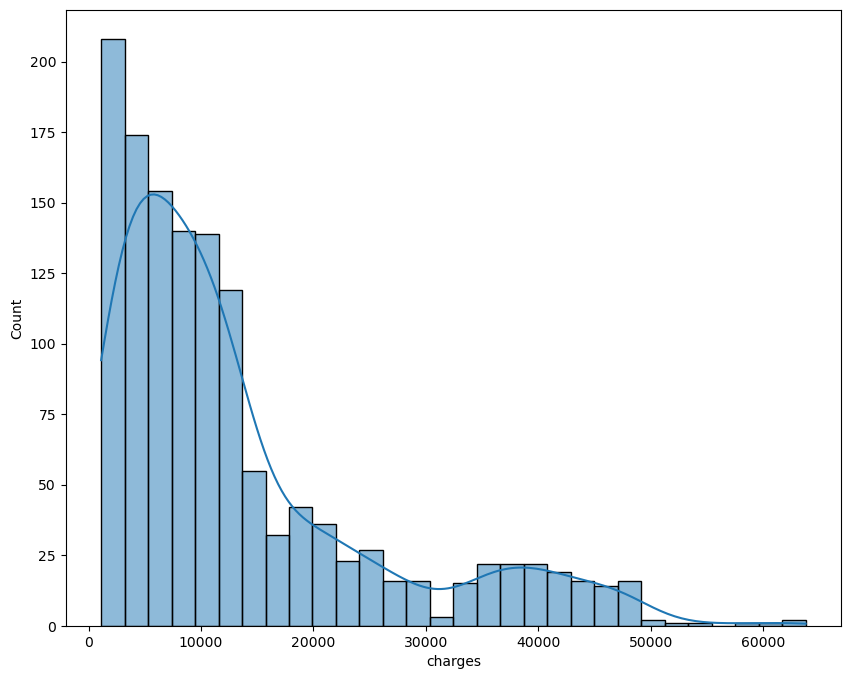

In [13]:
# cuantas casas tienen de media el valor que indica el eje x
sns.histplot(data = df, x = 'charges', kde = True);

La variable respuesta no es normal -- aunque tiene una forma normal, con cierto sesgo hacia la izquierda.

In [16]:
stats.shapiro(df["charges"])

ShapiroResult(statistic=0.8146880865097046, pvalue=1.1505194006561963e-36)

otra de las soluciones posibles, sin transformar la gráfica sería dividir el conjunto de datos y quitarnos la parte de la derecha, ya que es la parte que no es simétrica de la distriución.

In [17]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


## Variables predictoras

### Variables numéricas


In [27]:
# exploramos cuáles son los principales estadísticos de las variables numéricas

df_numericas = df.select_dtypes(include = np.number)#.describe()
df_numericas

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1333,50,30.970,3,10600.54830
1334,18,31.920,0,2205.98080
1335,18,36.850,0,1629.83350
1336,21,25.800,0,2007.94500


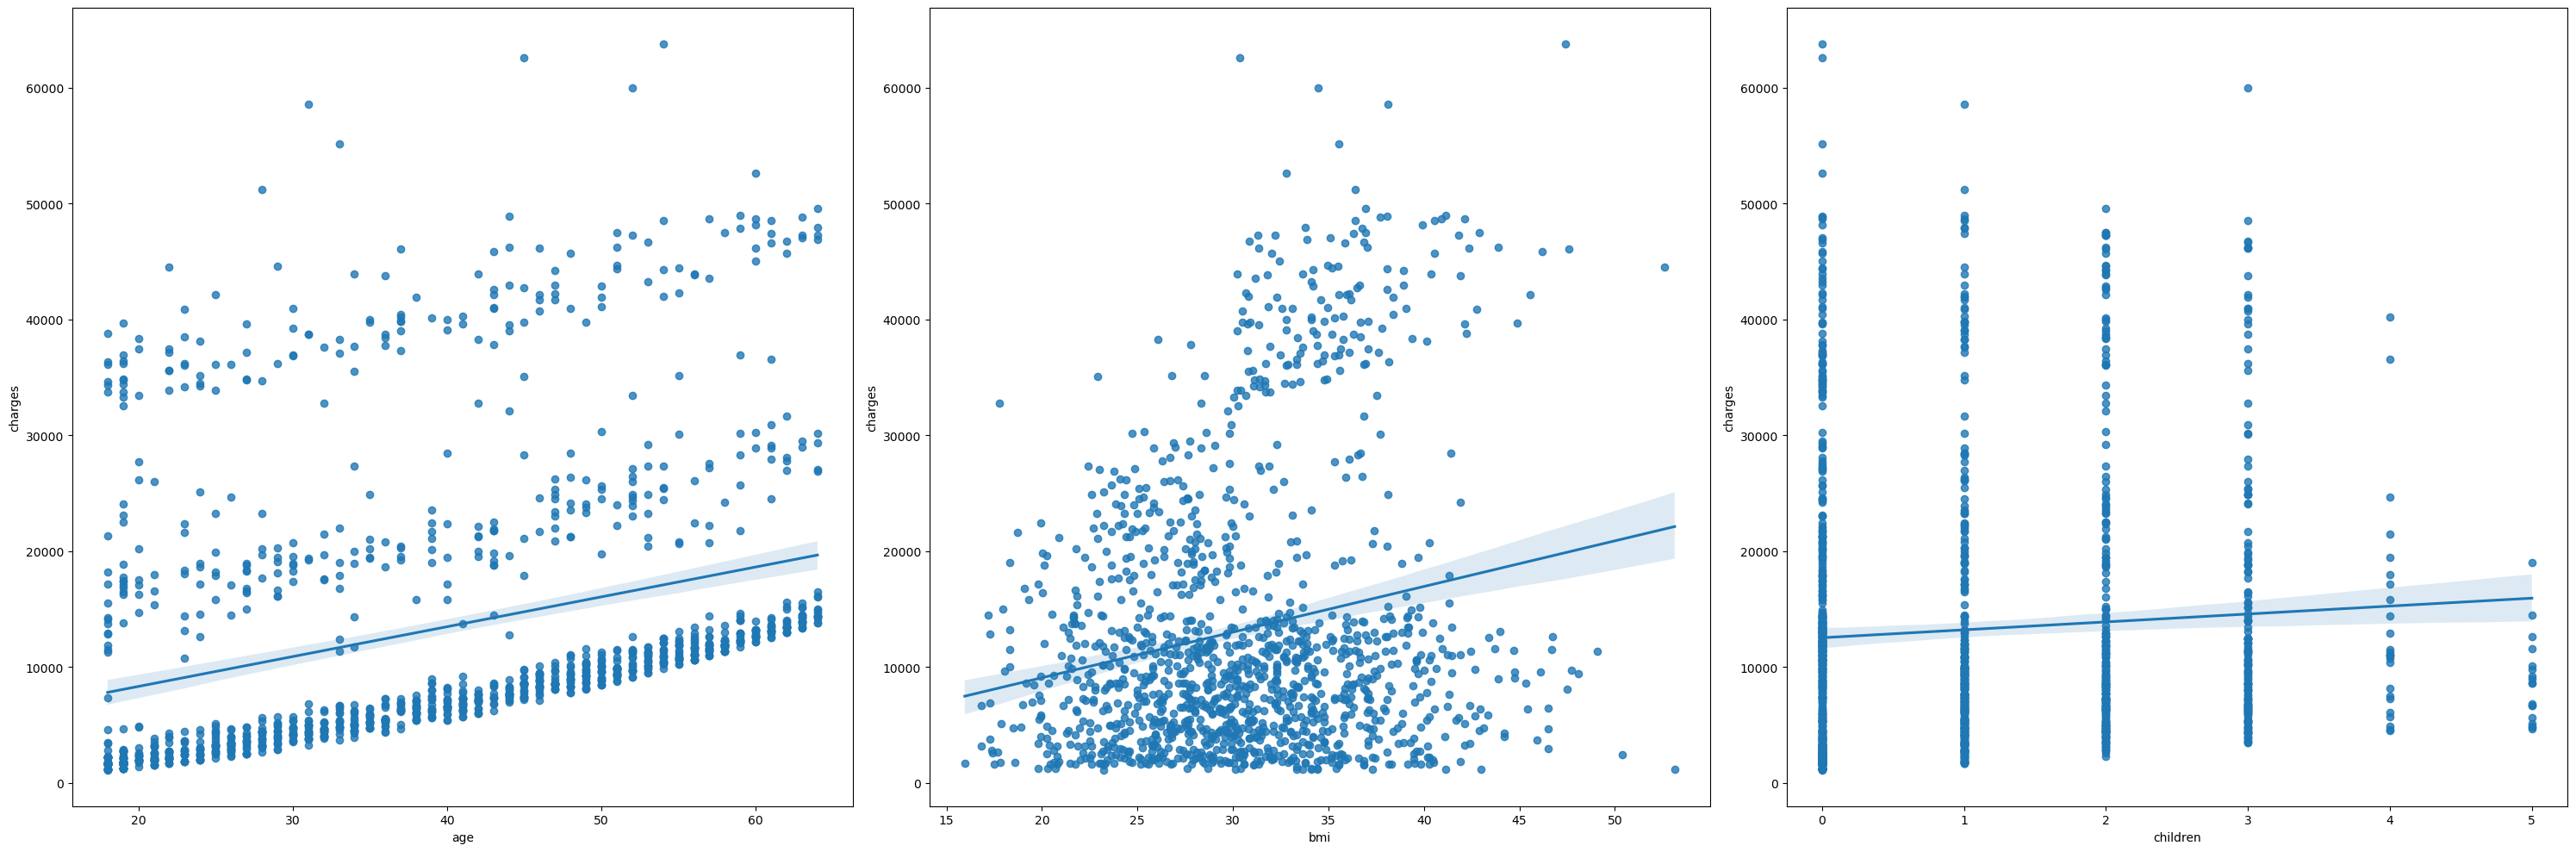

In [28]:
fig, axes = plt.subplots(ncols=3, figsize = (30,10))
axes = axes.flat
columnas = df_numericas.drop(['charges'], axis = 1)  
for i, columns in enumerate(columnas.columns):
    sns.regplot(data = df, x = columns, y = 'charges', ax = axes[i])
fig.tight_layout()

vale, confirmamos que la variable `children` es numérica, pero se puede considerar una variable categórica con 6 categorías.

la variable `bmi` se dispersa.

la variable `age` tiene una distribución más extraña -- parece que tiene tres partes que son lineales.

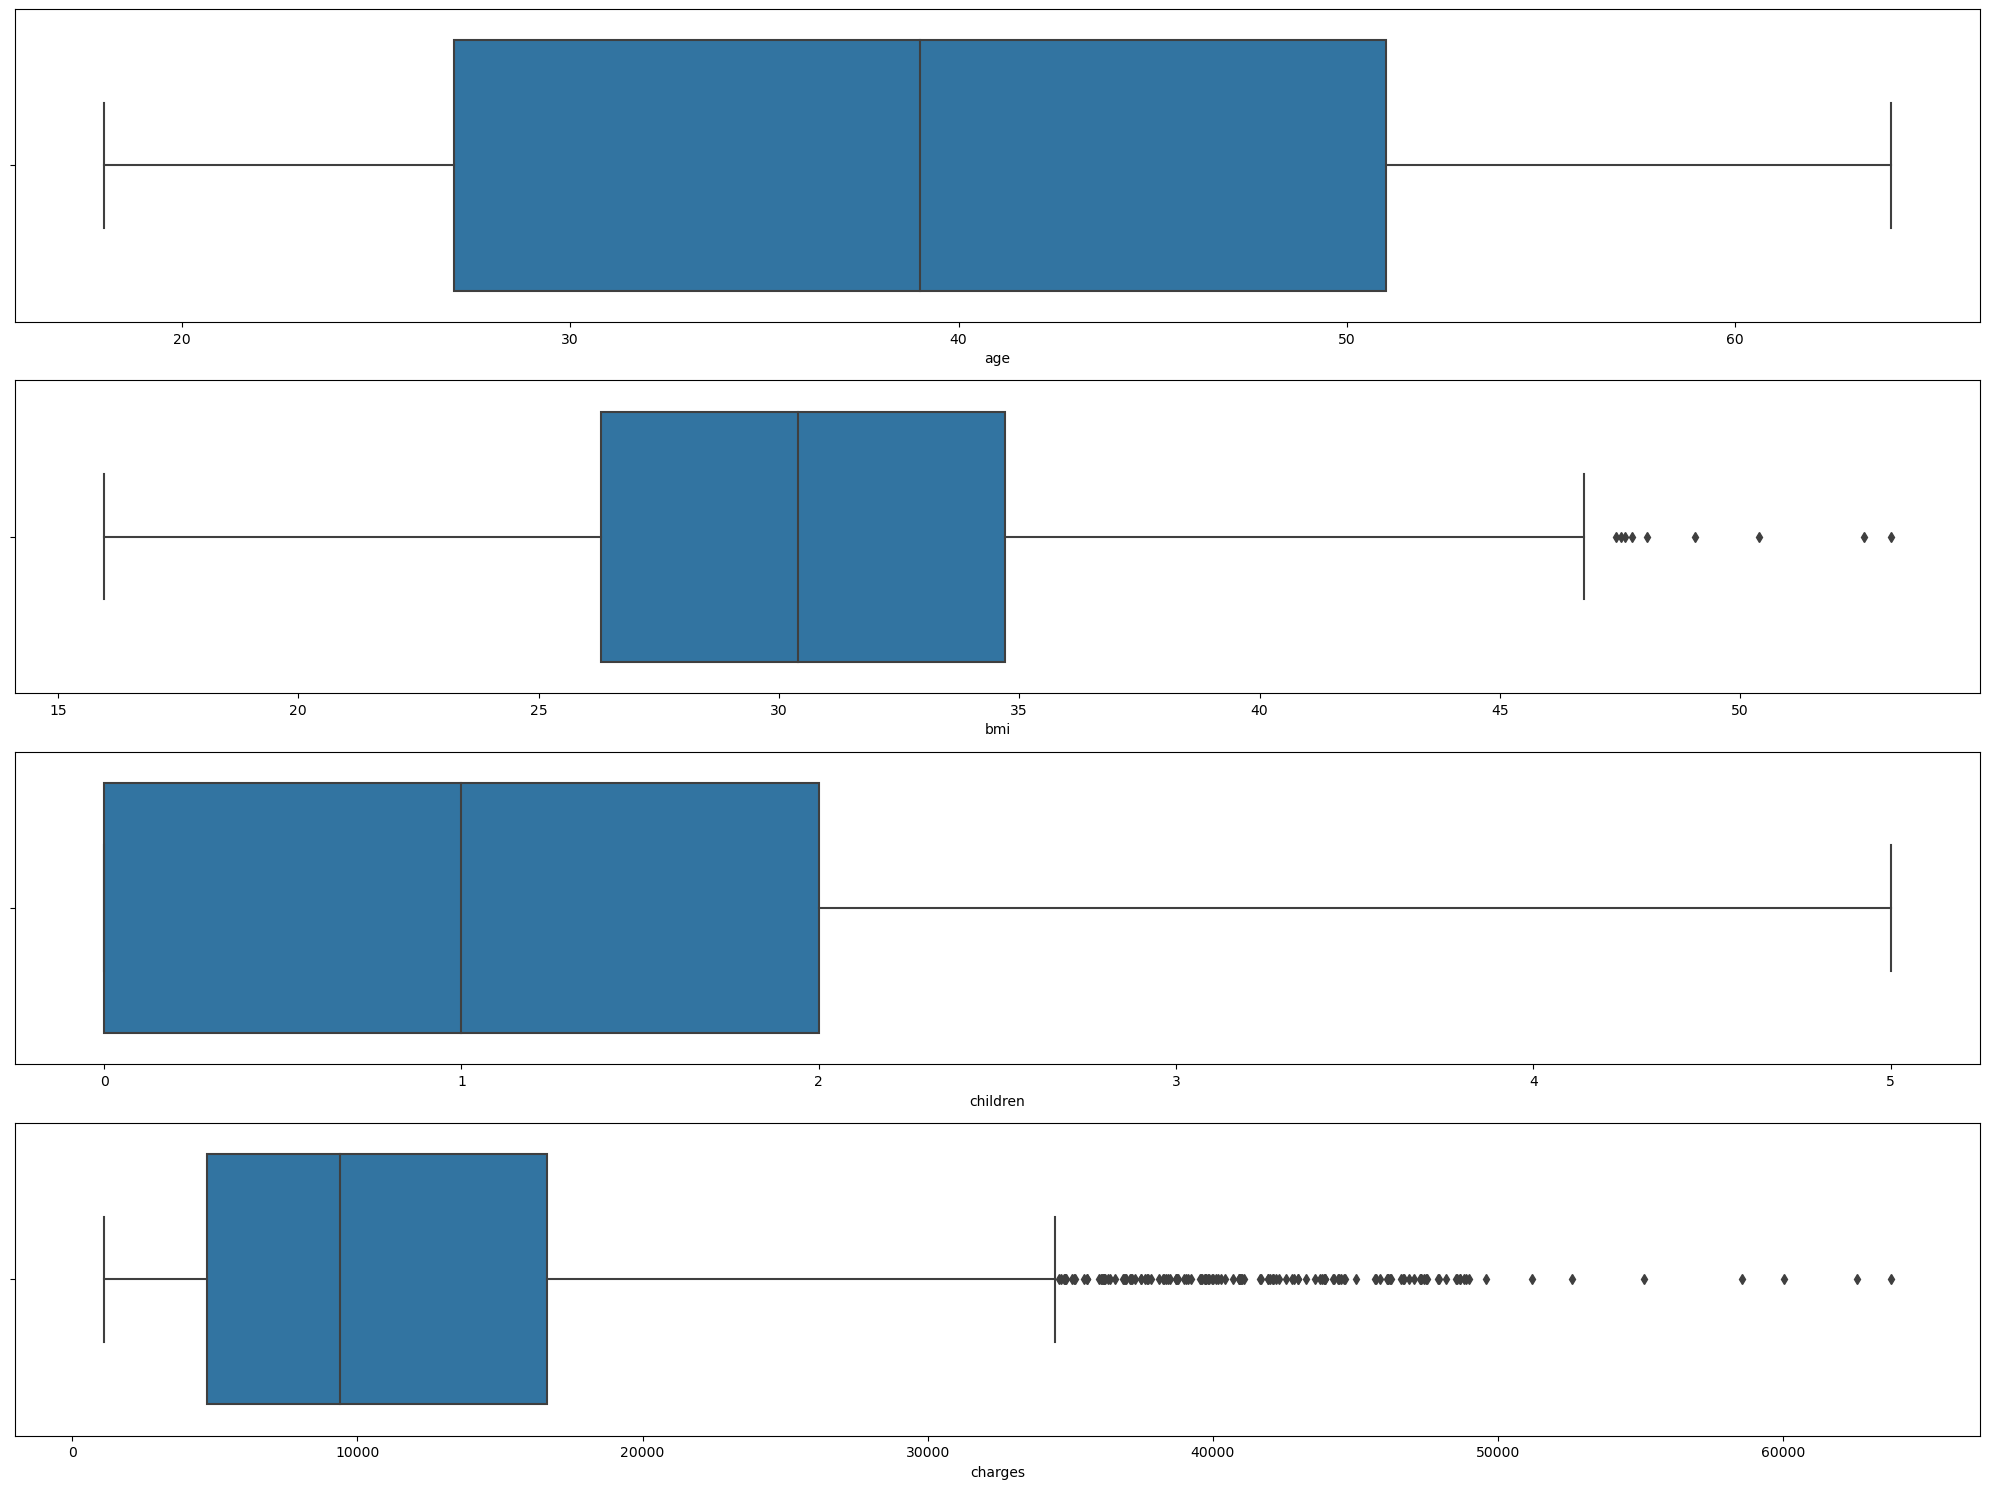

In [29]:
fig, ax = plt.subplots(4, 1, figsize=(20,15))

for i in range(len(df_numericas.columns)):
    sns.boxplot(x=df_numericas.columns[i], data=df_numericas, ax=ax[i])
plt.tight_layout()
plt.show();

Mirando la mezcla de variables respuesta + variables predictoras, vemos que donde hay outliers es en el campo `bmi` de las variables predictoras y en la varable respuesta `charges`.

### Correlación entre variables numéricas

ojo: solo entre variables numéricas

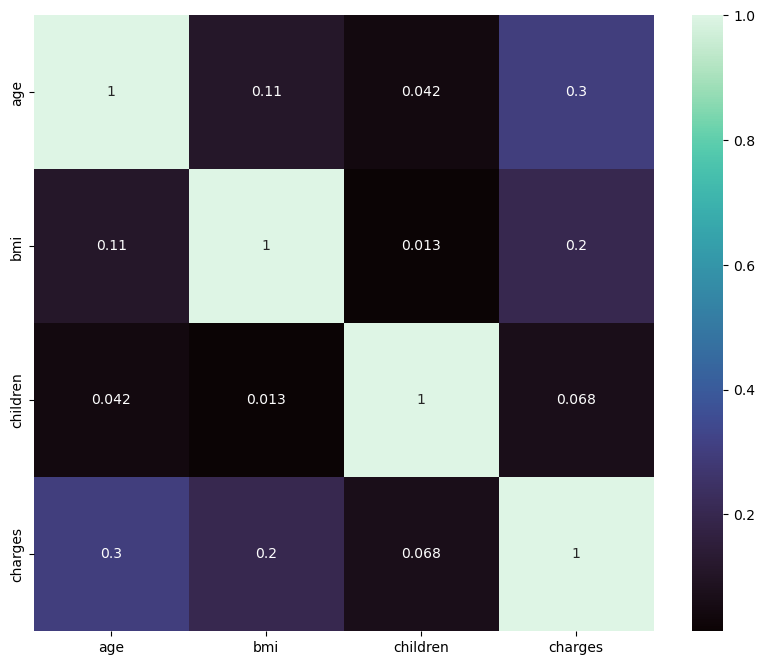

In [48]:
sns.heatmap(df.corr(), 
           cmap = "mako", 
           annot = True);

In [31]:
# creamos un dataframe todo de unos de la misma forma que nuestra matriz de correlación
## creamos una matriz triangular

mask = np.triu(np.ones_like(df.corr(), dtype = np.bool))
mask


array([[ True,  True,  True,  True],
       [False,  True,  True,  True],
       [False, False,  True,  True],
       [False, False, False,  True]])

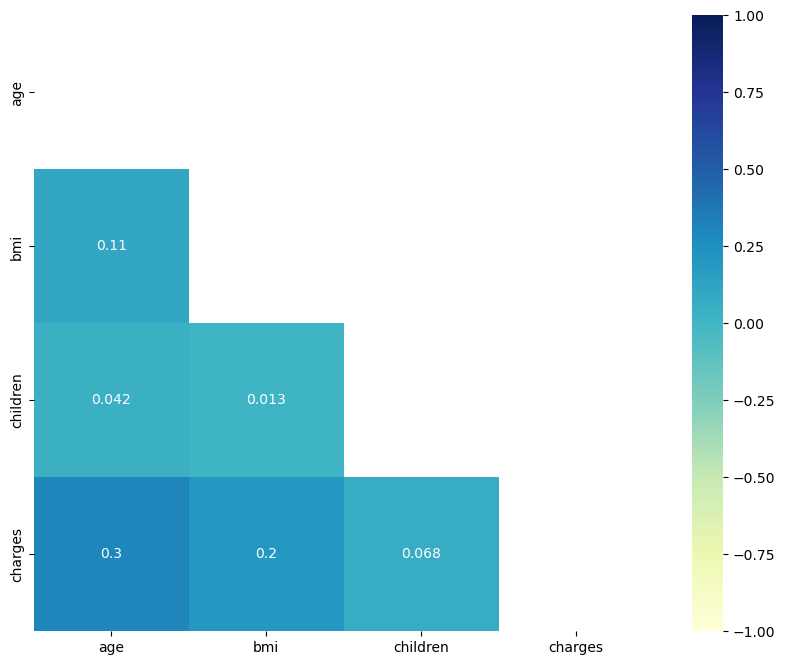

In [32]:
sns.heatmap(df.corr(), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True,
           vmin = -1,
           vmax = 1
           );
## ojo, incluir los valores max y min para ver la escala total
## para ver si hay correlación entre dos variables, hay que ver si los valores están en torno al 0.6 - 0.7

Mirando la matriz de correlación, la variable que más influye en la variable respuesta es `age`.

### Variables categóricas

In [33]:
df_categoricas = df.select_dtypes(include='object')
df_categoricas.head()

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest


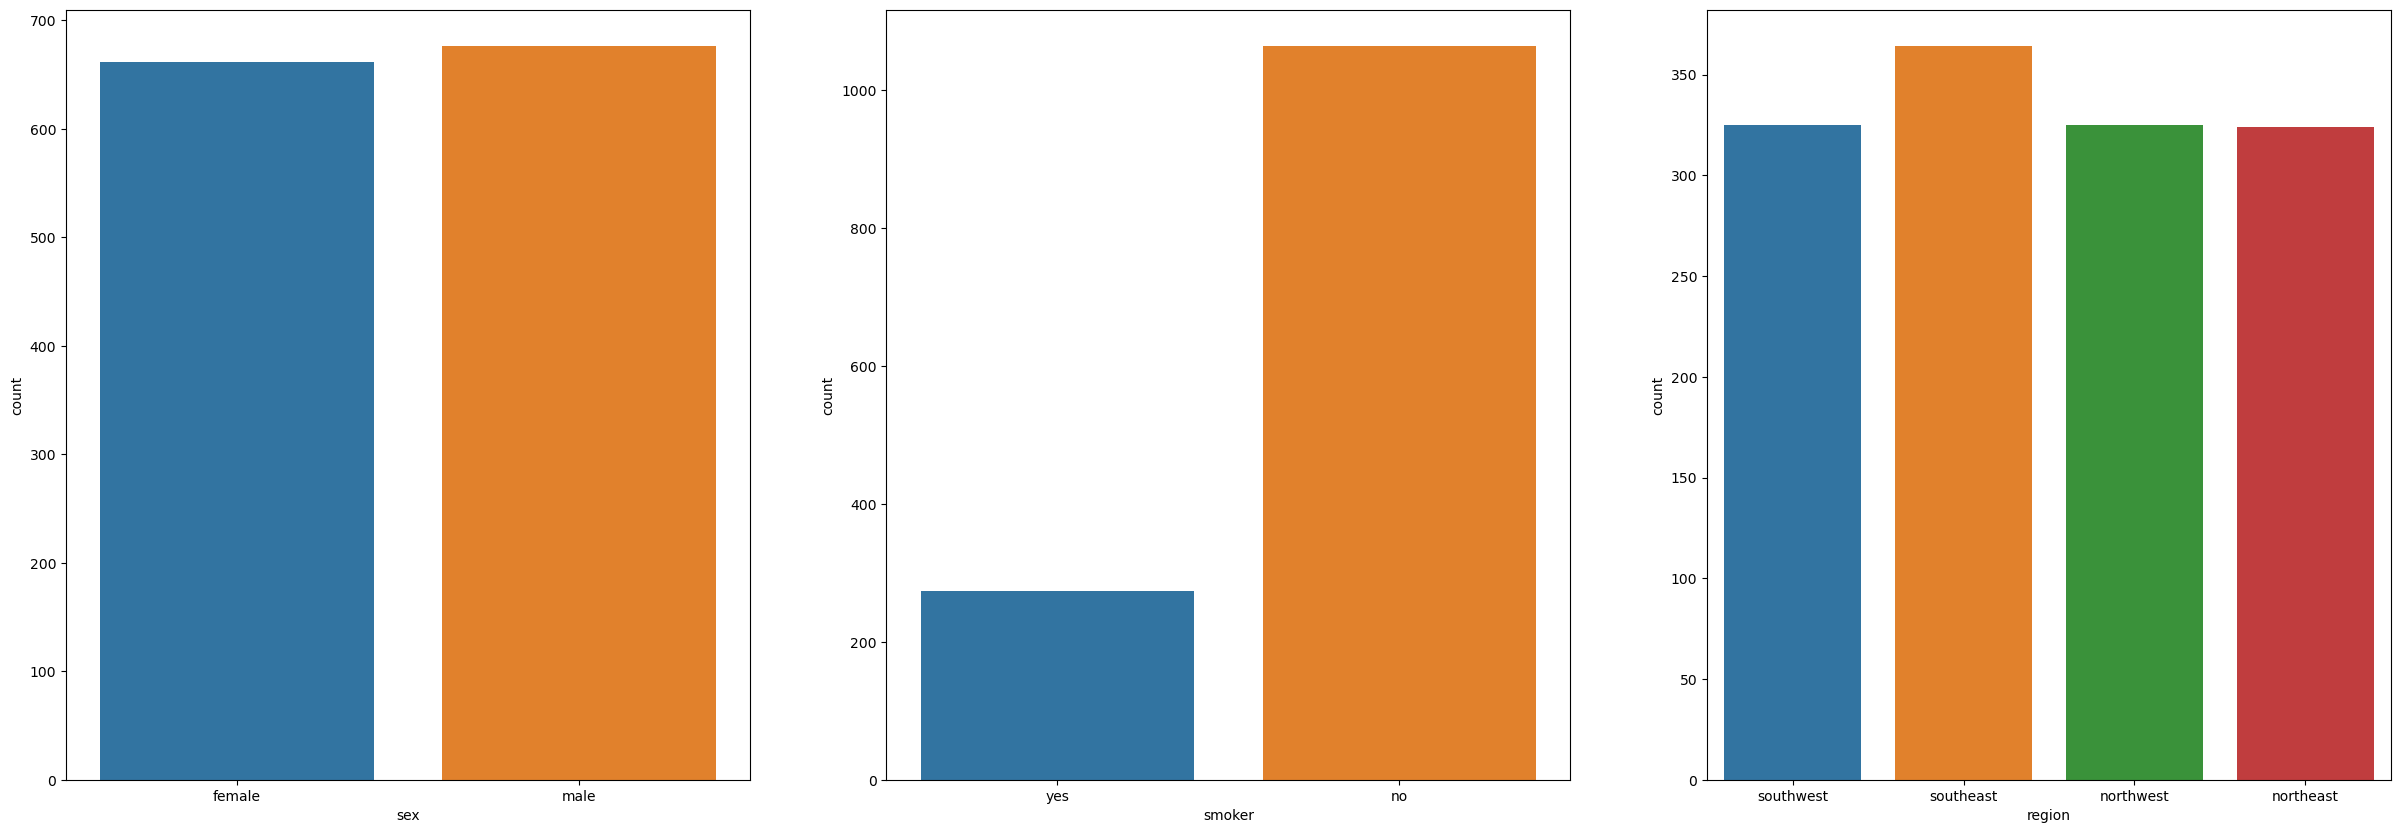

In [34]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))

axes = axes.flat

for i, columna in enumerate(df_categoricas.columns):
    sns.countplot(data = df, 
                  x = columna, 
                  ax = axes[i]);

Vemos que tanto `sex` como `region`. Lo que sí que vemos que hay una diferencia significativa es en la cantidad de fumadores. Veamos como se relacionan las variables con los valores de `charges`.

vamos a sacar el precio medio por estados y ver como se distribuyen los precios:

In [40]:
df_cate_sex = df.groupby('sex')['charges'].mean().reset_index()
df_cate_sex.head()

,sex,charges
0,female,12569.578844
1,male,13956.751178


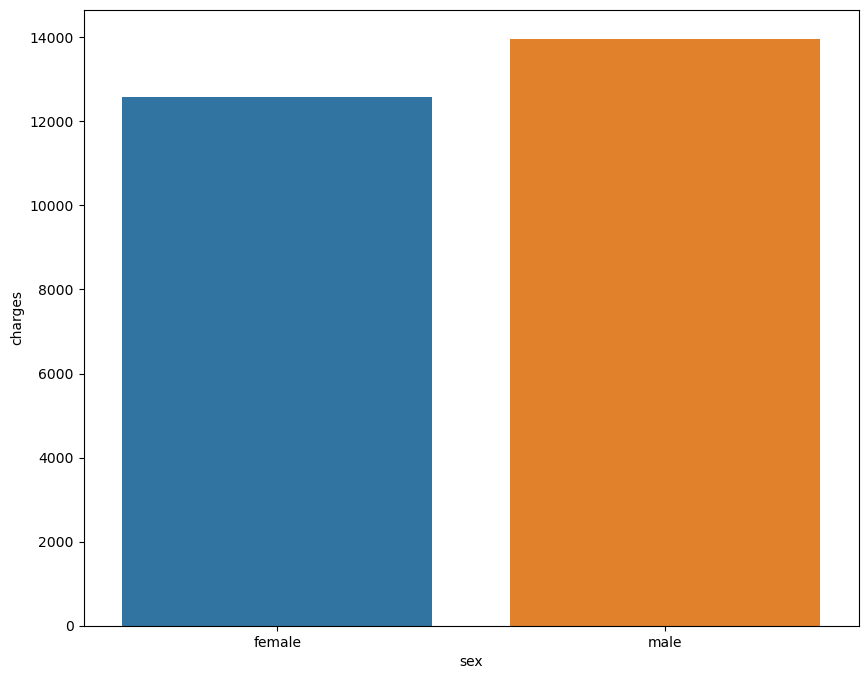

In [41]:
sns.barplot(data=df_cate_sex, x = 'sex', y = 'charges');

In [46]:
df_cate_smoker = df.groupby('smoker')['charges'].mean().reset_index()
df_cate_smoker.head()

,smoker,charges
0,no,8434.268298
1,yes,32050.231832


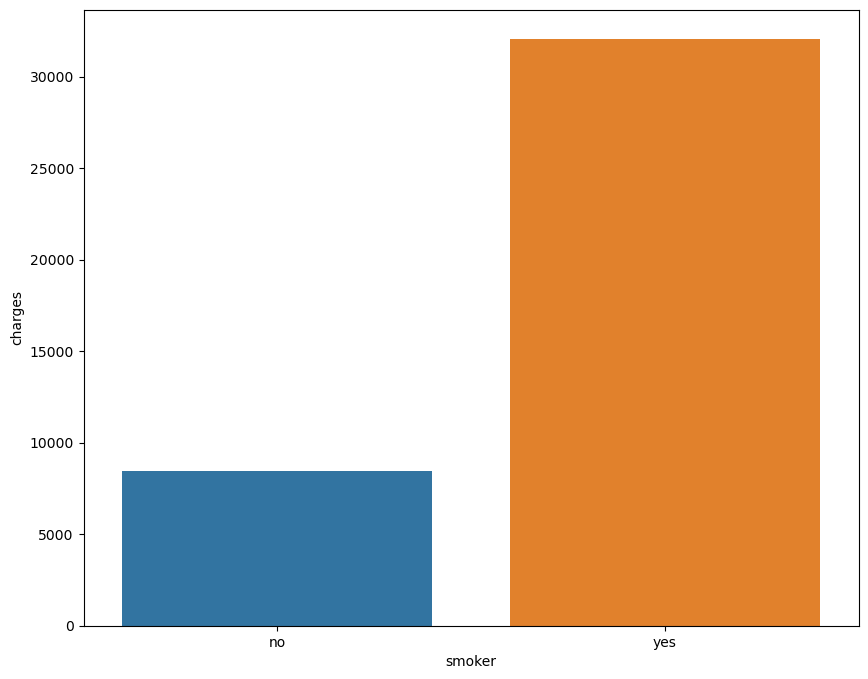

In [47]:
sns.barplot(data=df_cate_smoker, x = 'smoker', y = 'charges');

In [44]:
df_cate_smoker = df.groupby('region')['charges'].mean().reset_index()
df_cate_smoker.head()

,region,charges
0,northeast,13406.384516
1,northwest,12417.575374
2,southeast,14735.411438
3,southwest,12346.937377


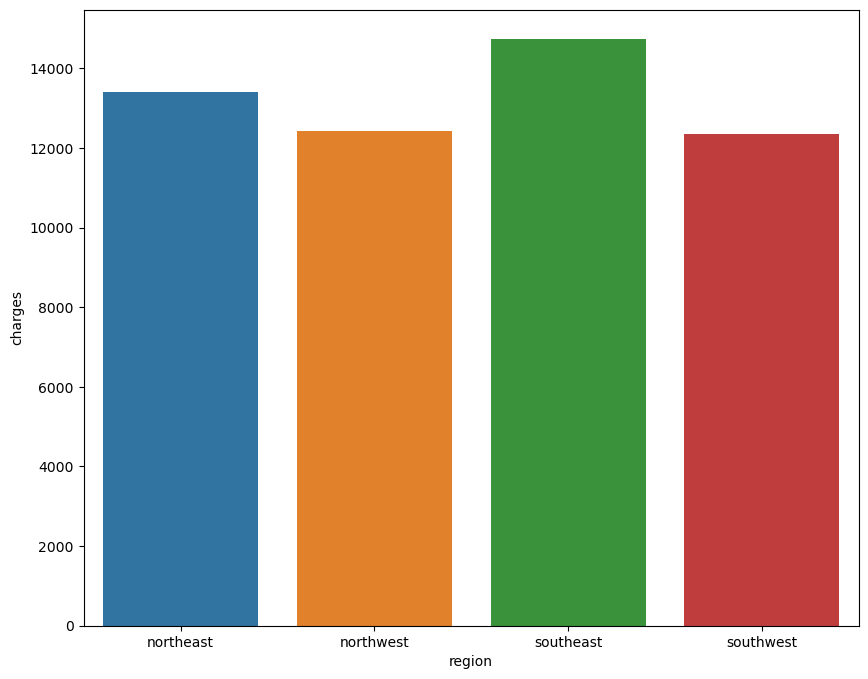

In [45]:
sns.barplot(data=df_cate_smoker, x = 'region', y = 'charges');

Mirando el valor de la prima para las variables categóricas, la que más variabilidad tiene es `smokers`, ya que si la persona es fumadora tiene mucho más valor de `charges` que si no lo es.

# Gestión outliers

Lo que hemos visto en la observación de los datos, es que las columnas numéricas que más outliers tienen son `bmi` y la propia variable respuesta `charges`.

También es muy significativo como varía el valor de `charges` en función a la variable categórica `smokers`. Si las personas son fumadoras, parecen pagar más primas.

## hipótesis 01: quitamos los valores de `bmi` anómalos

In [56]:
df_bmi = df.copy()
df_bmi.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [50]:
def detectar_outliers(lista_columnas, dataframe):

    dict_indices = {}

    for i in lista_columnas:
        Q1 = np.nanpercentile(dataframe[i], 25)
        Q3 = np.nanpercentile(dataframe[i], 75)

        IQR = Q3 - Q1

        outlier_step = IQR * 1.5

        outliers_value = dataframe[(dataframe[i] < Q1 - outlier_step) | (dataframe[i] > Q3 + outlier_step)]

        if outliers_value.shape[0] > 0:
            dict_indices[i] = outliers_value.index.tolist()
        else:
            #dict_indices[i] = 'sin outliers'
            pass
    return dict_indices

In [53]:
dic_outliers = detectar_outliers(df_numericas.columns, df)
print(dic_outliers)

{'bmi': [116, 286, 401, 543, 847, 860, 1047, 1088, 1317], 'charges': [14, 19, 23, 29, 30, 34, 38, 39, 49, 53, 55, 82, 84, 86, 94, 109, 123, 146, 158, 161, 175, 185, 203, 223, 240, 242, 251, 252, 254, 256, 263, 265, 271, 281, 288, 292, 298, 312, 314, 322, 327, 328, 330, 338, 373, 377, 381, 420, 421, 422, 441, 476, 488, 500, 524, 530, 543, 549, 558, 569, 577, 587, 609, 615, 621, 623, 629, 665, 667, 668, 674, 677, 682, 689, 697, 706, 725, 736, 738, 739, 742, 759, 803, 819, 826, 828, 842, 845, 850, 852, 856, 860, 883, 893, 901, 917, 947, 951, 953, 956, 958, 1012, 1021, 1022, 1031, 1036, 1037, 1047, 1049, 1062, 1070, 1078, 1090, 1096, 1111, 1117, 1118, 1122, 1124, 1139, 1146, 1152, 1156, 1186, 1206, 1207, 1218, 1230, 1240, 1241, 1249, 1284, 1288, 1291, 1300, 1301, 1303, 1313, 1323]}


In [57]:
indices_bmi = dic_outliers['bmi']
df_bmi.drop(indices_bmi, axis = 0, inplace=True)
df_bmi.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


vamos a ver si los outlliers variarían mucho retirando los outliers

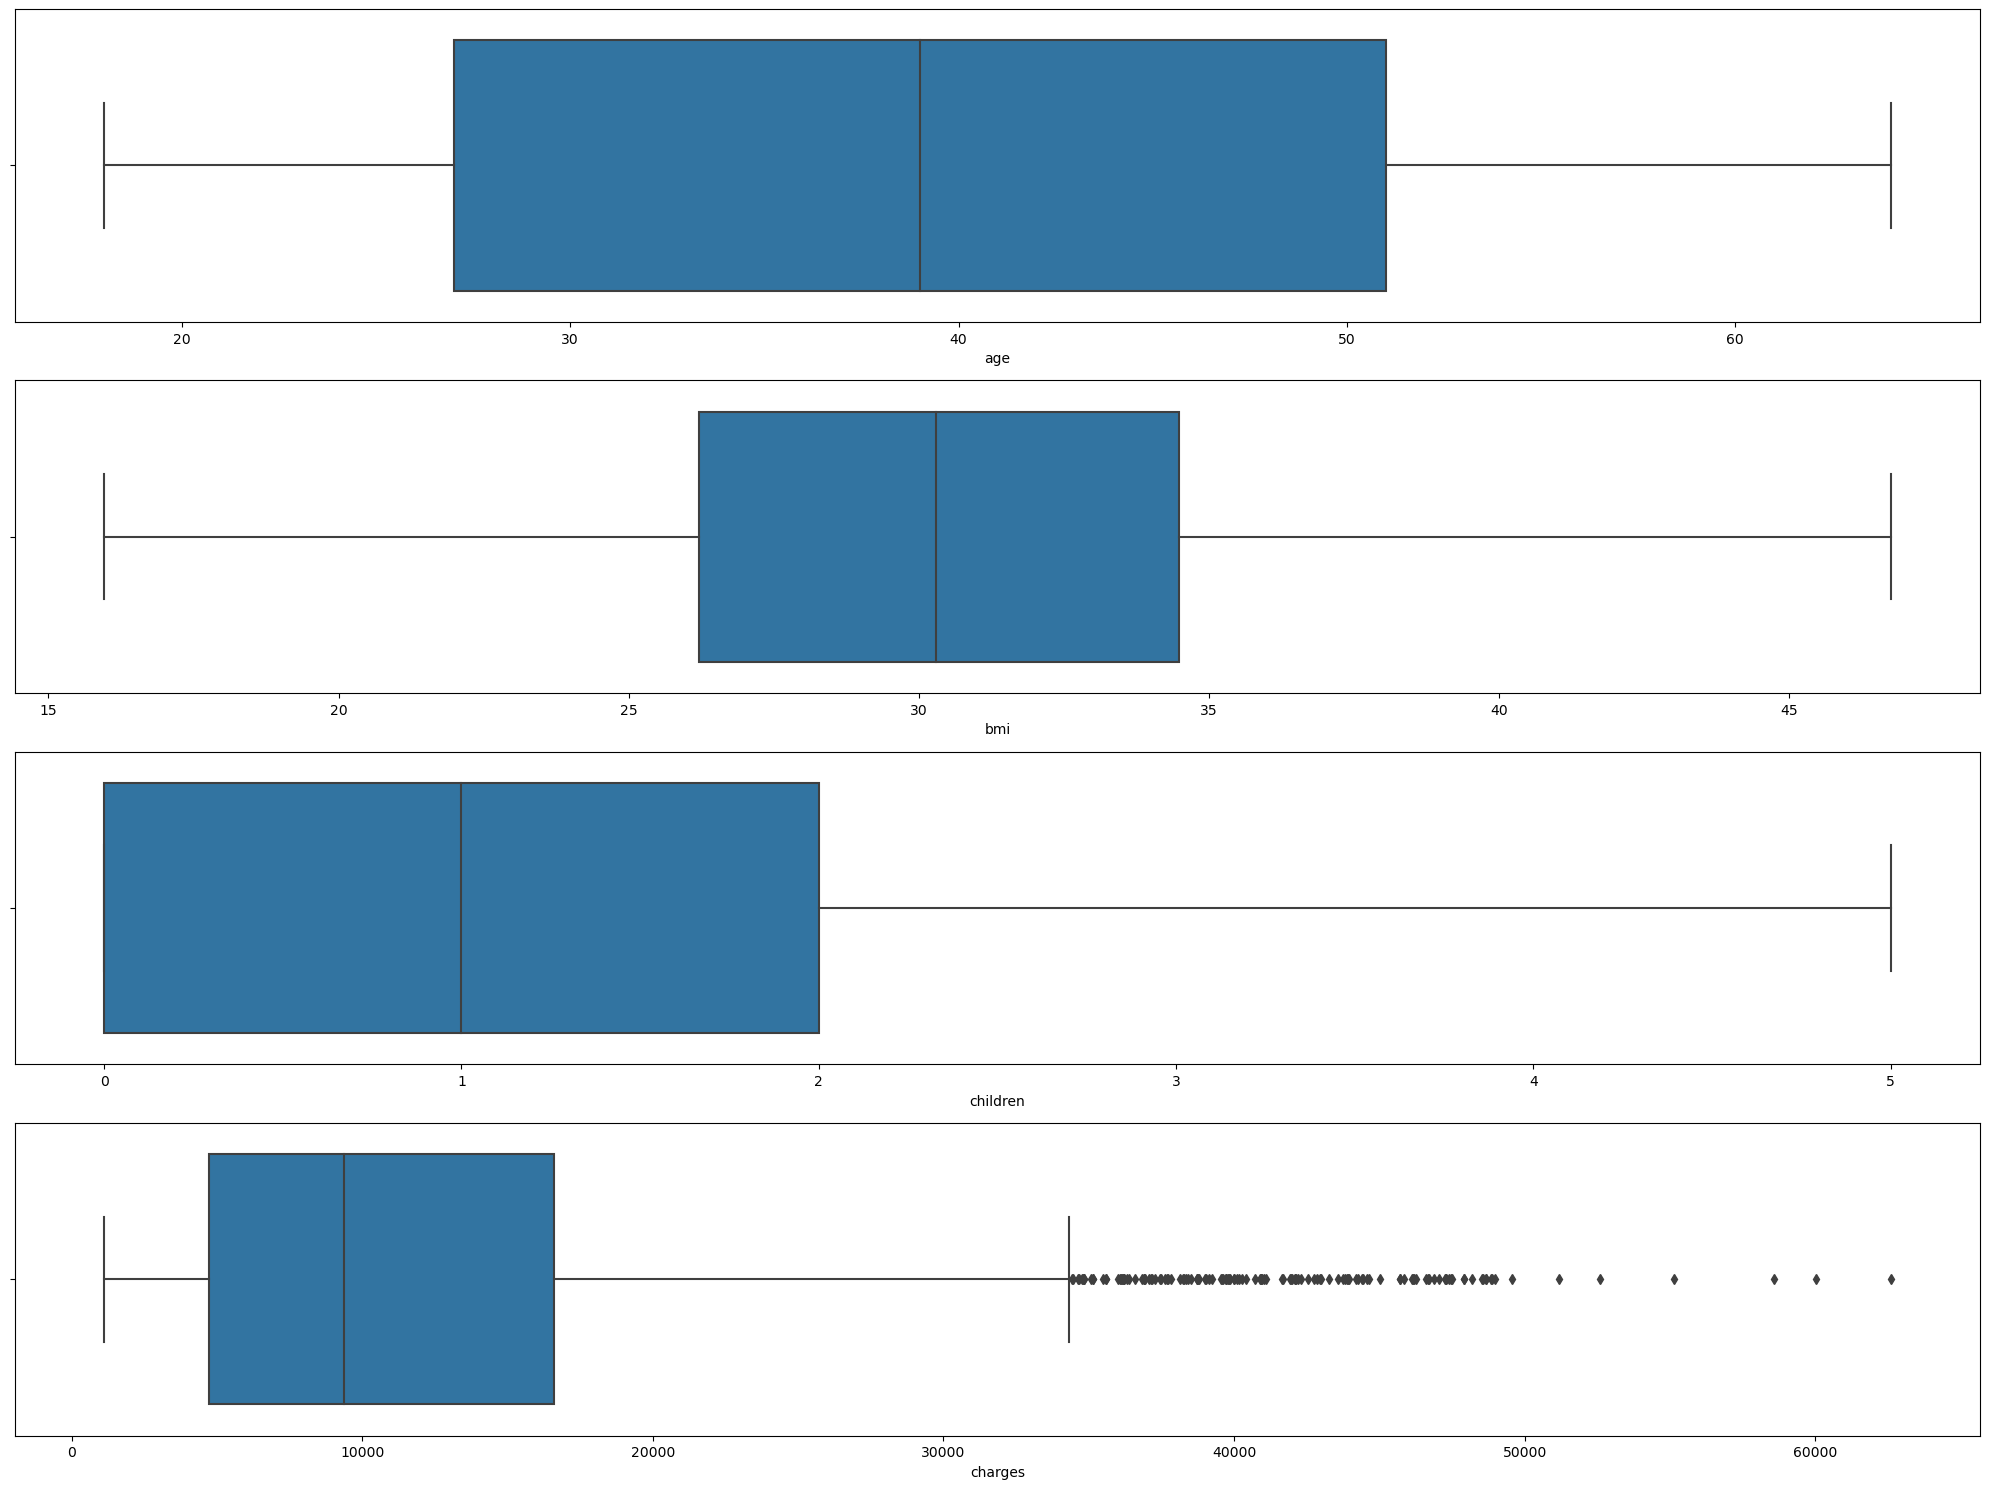

In [60]:
df_bmi_numericas = df_bmi.select_dtypes(include=np.number)

fig, ax = plt.subplots(4, 1, figsize=(20,15))

for i in range(len(df_bmi_numericas.columns)):
    sns.boxplot(x=df_bmi_numericas.columns[i], data=df_bmi_numericas, ax=ax[i])
plt.tight_layout()
plt.show();

pese a retirando los outliers de `bmi`, sigo teniendo muchos valores anómalos de `charges`. voy a examinar las variables categóricas.

In [61]:
df_cate_sex = df_bmi.groupby('sex')['charges'].mean().reset_index()
df_cate_sex.head()

,sex,charges
0,female,12445.742535
1,male,13966.338394


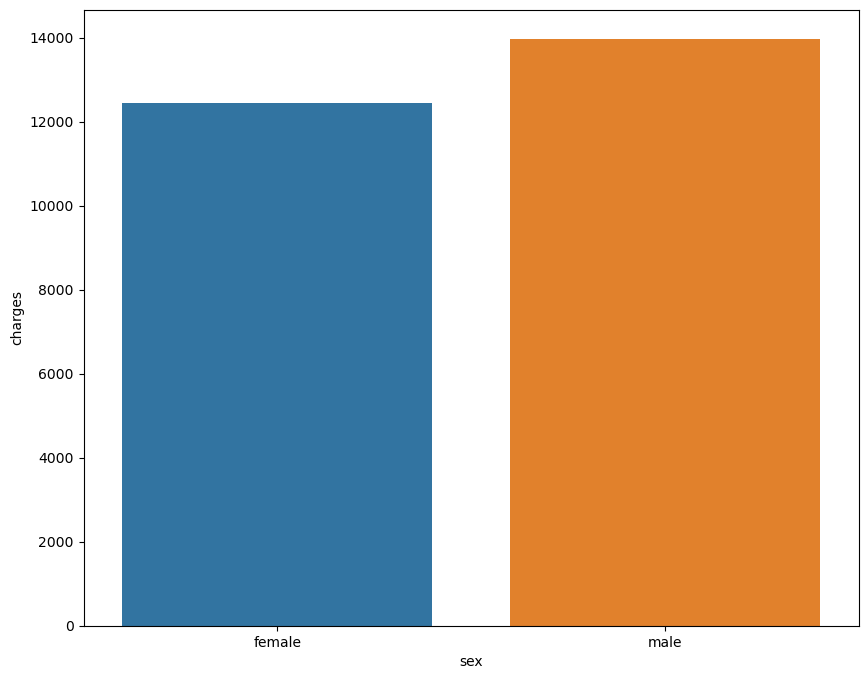

In [62]:
sns.barplot(data=df_cate_sex, x = 'sex', y = 'charges');

In [63]:
df_cate_smoker = df_bmi.groupby('smoker')['charges'].mean().reset_index()
df_cate_smoker.head()

,smoker,charges
0,no,8442.167174
1,yes,31835.343855


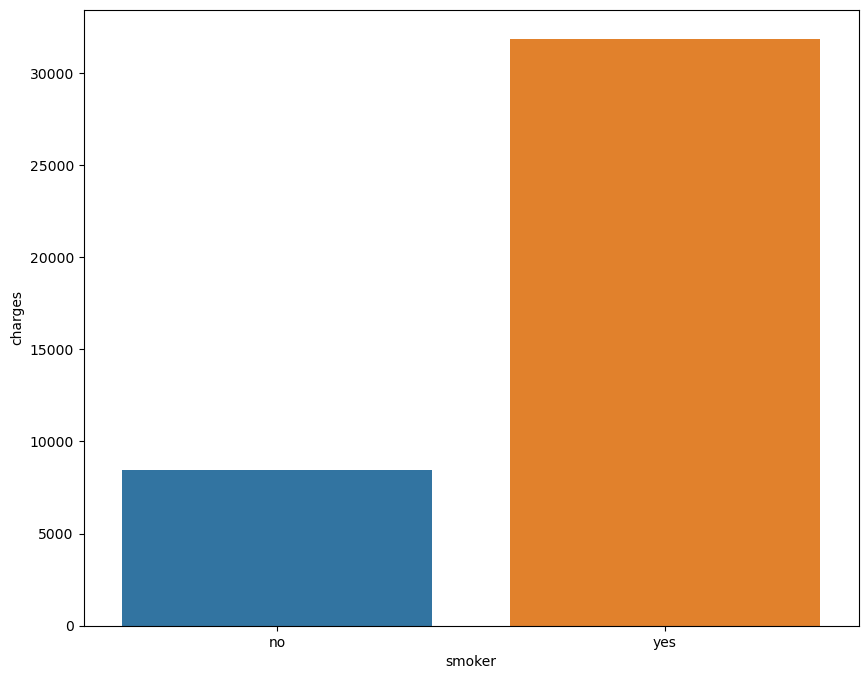

In [64]:
sns.barplot(data=df_cate_smoker, x = 'smoker', y = 'charges');

In [65]:
df_cate_smoker = df_bmi.groupby('region')['charges'].mean().reset_index()
df_cate_smoker.head()

,region,charges
0,northeast,13418.686248
1,northwest,12417.575374
2,southeast,14629.137993
3,southwest,12242.719557


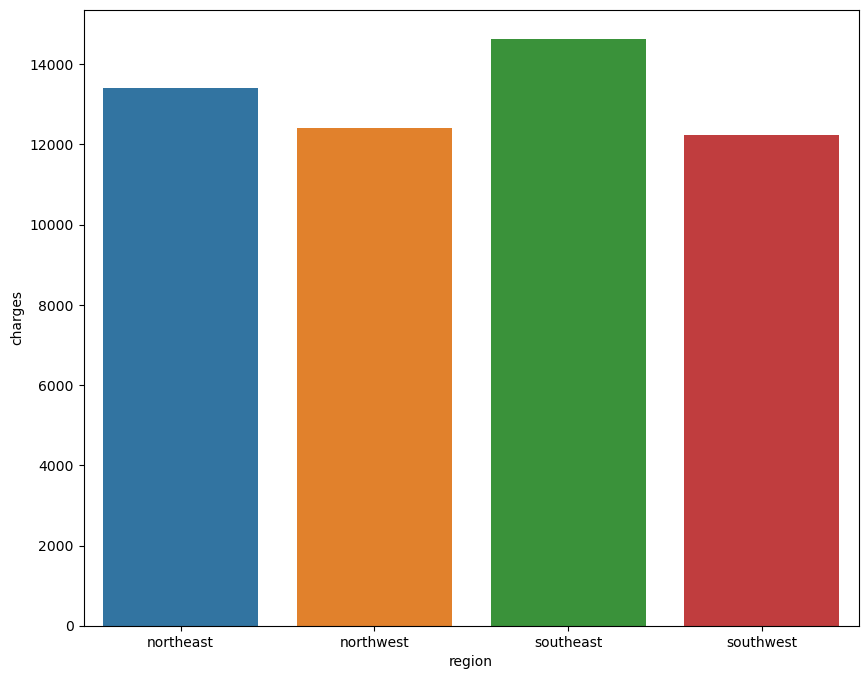

In [66]:
sns.barplot(data=df_cate_smoker, x = 'region', y = 'charges');

sigue ocurriendo lo mismo -- la media de `charges` según los `smokers` sigue siendo muy alta para los fumadores.

## hipótesis 02: fumadores o no fumadores

In [67]:
df_smoker = df[df['smoker'] == 'yes']
df_non_smoker = df[df['smoker'] != 'yes']
df_smoker.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
11,62,female,26.29,0,yes,southeast,27808.7251
14,27,male,42.13,0,yes,southeast,39611.7577
19,30,male,35.30,0,yes,southwest,36837.4670
23,34,female,31.92,1,yes,northeast,37701.8768


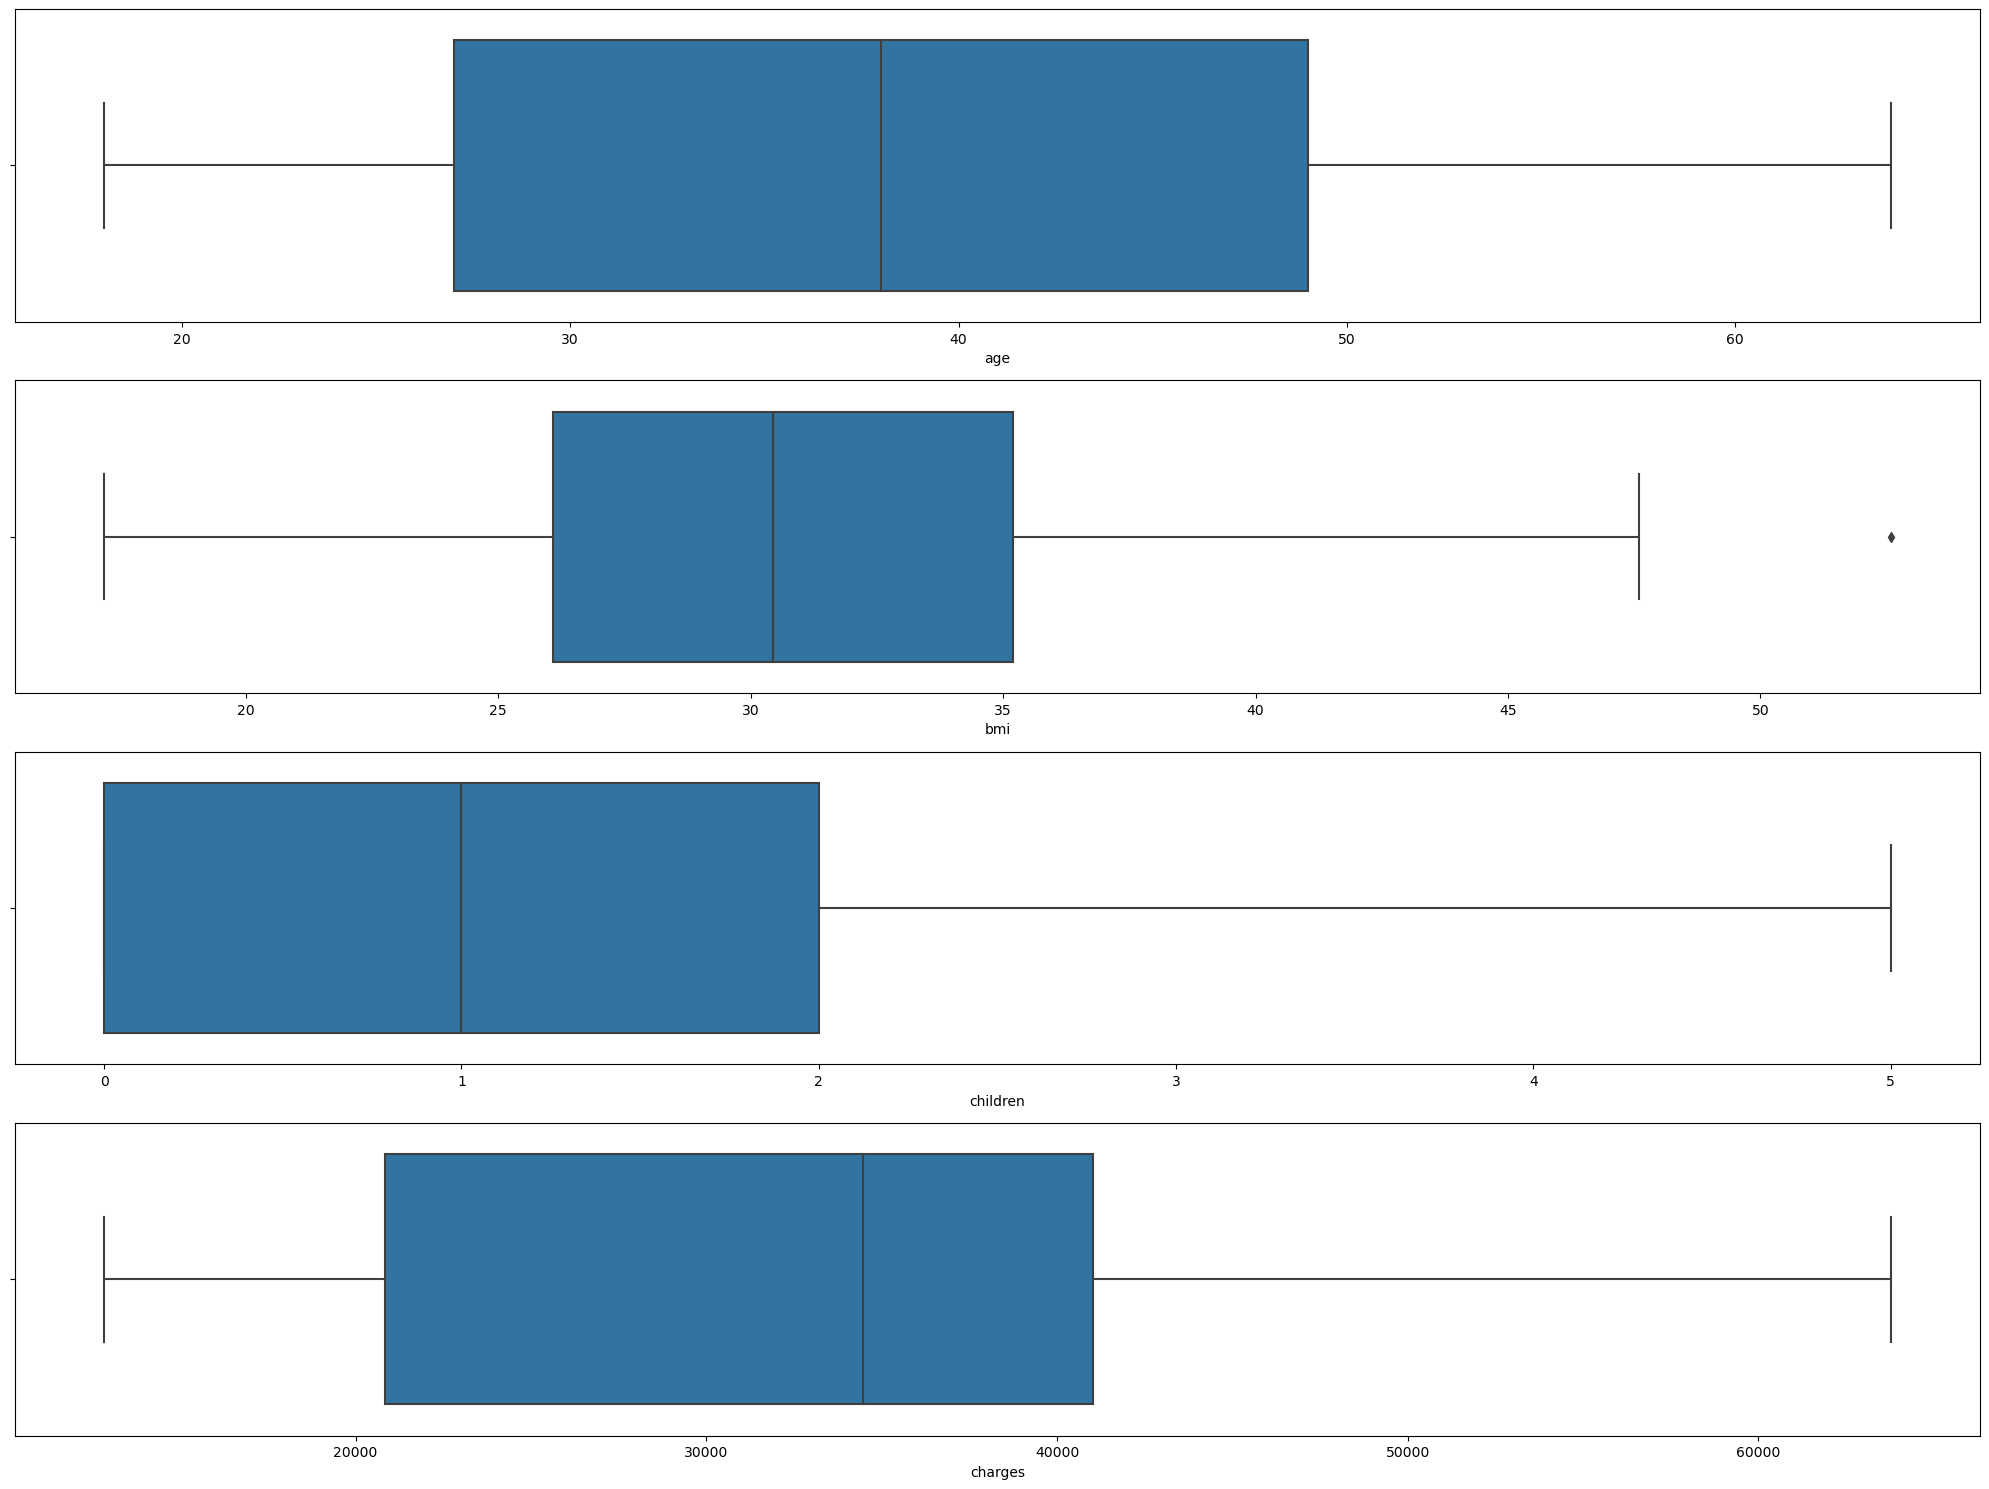

In [68]:
df_smoker_numericas = df_smoker.select_dtypes(include=np.number)

fig, ax = plt.subplots(4, 1, figsize=(20,15))

for i in range(len(df_smoker_numericas.columns)):
    sns.boxplot(x=df_smoker_numericas.columns[i], data=df_smoker_numericas, ax=ax[i])
plt.tight_layout()
plt.show();